## Preprocessing

In [1]:
import os
import sys

import sys
sys.path.append(os.path.join('.', 'Code'))
sys.path.append(os.path.join('.', 'Code', 'all_models', 'wgan_gp'))
sys.path.append(os.path.join('.', 'Code', 'all_models', 'arima'))
sys.path.append(os.path.join('.', 'Code', 'all_models', 'gru_lstm'))

import inspect
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import models
from tensorflow.keras import callbacks

from preprocessing import *
from test_pred import *
from plot_data import *

from customCallBacks import *
from Discriminator import *
from Generator import *
from Metric_rmse_scaled import *
from Wgan_gp import *

from gru import *
from lstm import *
from bidir_lstm import *

from pmdarima.arima import auto_arima

In [2]:
N_STEPS_IN = 3
N_STEPS_OUT = 1

# WGAN-GP

In [3]:
# Hyperparameter
EPOCHS = 200
BATCH_SIZE = 128
D_STEPS = 1
G_STEPS = 3
GP_WEIGHT = 10
D_LEARNING_RATE = 0.0001
G_LEARNING_RATE = 0.0001

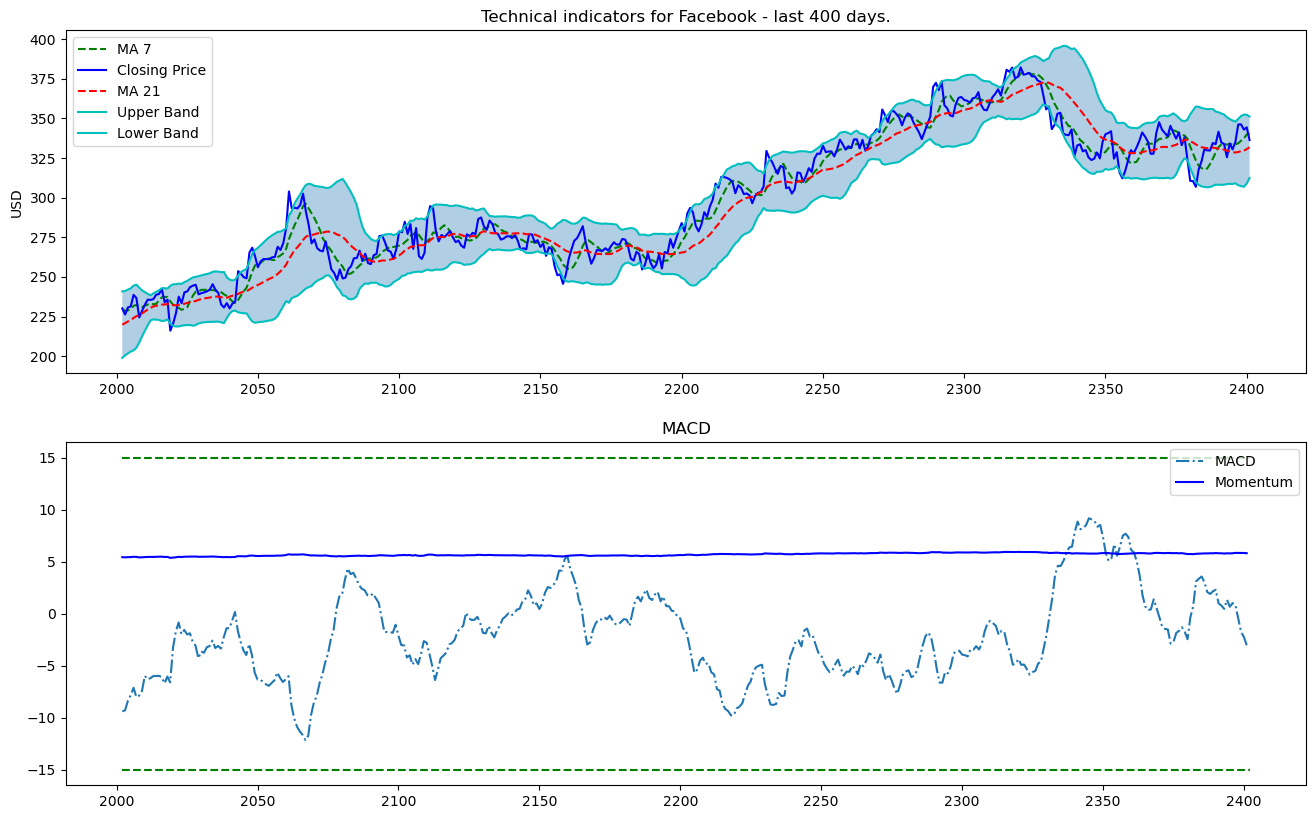

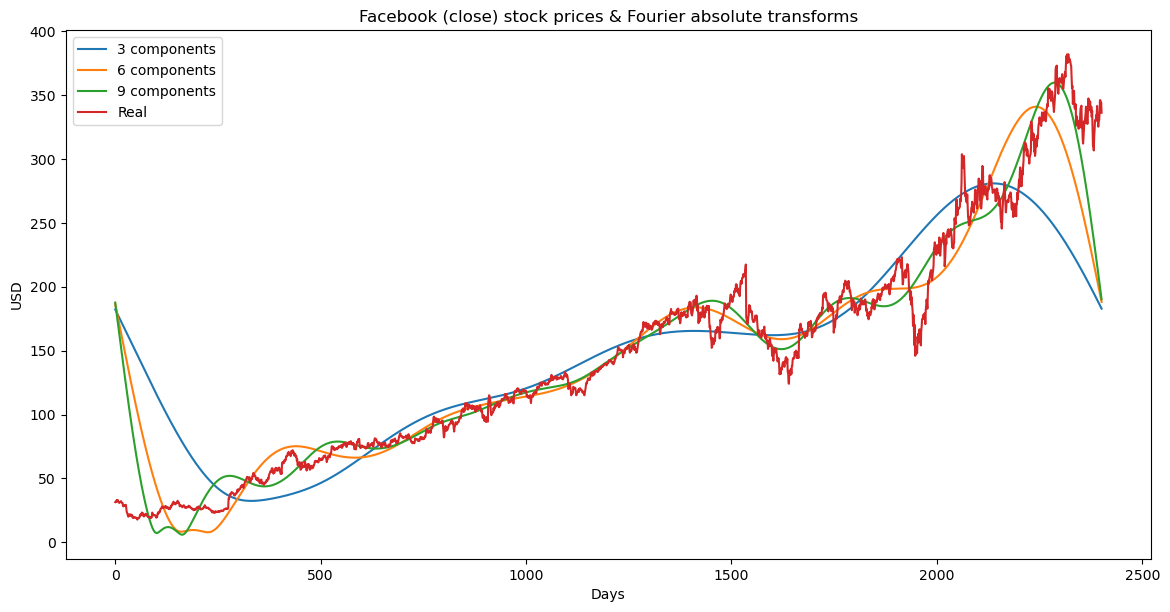

X shape:  (2399, 3, 36)
y shape:  (2399, 1)
X_train shape:  (1679, 3, 36)
y_train shape:  (1679, 1)
y_c_train shape:  (1679, 3, 1)
X_test shape:  (720, 3, 36)
y_test shape:  (720, 1)
y_c_test shape:  (720, 3, 1)
index_train shape: (1679,)
index_test shape: (720,)
Everything saved in  Data\dataPreprocessed


In [4]:
#----------------------    Load Data    -----------------------
data = pd.read_csv(r'Data\DataFacebook.csv', parse_dates=['date'])
y_scaler_function = all_preprocessing(data, N_STEPS_IN, N_STEPS_OUT, plot=True)

path = r'Data\dataPreprocessed'
X_train = np.load(os.path.join(path, "X_train.npy"), allow_pickle=True)
y_train = np.load(os.path.join(path, "y_train.npy"), allow_pickle=True)
X_test = np.load(os.path.join(path, "X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path, "y_test.npy"), allow_pickle=True)
yc_train = np.load(os.path.join(path, "yc_train.npy"), allow_pickle=True)
yc_test = np.load(os.path.join(path, "yc_test.npy"), allow_pickle=True)

input_generator_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_generator_dim = y_train.shape[1]

data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, yc_train))
data_train = data_train.batch(BATCH_SIZE)

data_test = tf.data.Dataset.from_tensor_slices((X_test , y_test , yc_test ))
data_test = data_test.batch(BATCH_SIZE)

In [5]:
#----------------------    Training    -----------------------

# Instantiate the optimizer for both networks
discriminator_optimizer = tf.keras.optimizers.Adam(D_LEARNING_RATE)
generator_optimizer = tf.keras.optimizers.Adam(G_LEARNING_RATE)

generator = Generator(input_generator_dim, output_generator_dim, feature_size)
generator.compile()
discriminator = Discriminator(input_generator_dim, output_generator_dim)
wgan_gp = WGAN_GP(generator, discriminator, Metric_rmse_scaled(y_scaler_function), D_STEPS, G_STEPS, GP_WEIGHT)

# Compile the WGAN model.
wgan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss
)

save_path = r'Models\trying'
EPOCH_MODEL_SAVE = 1

es = callbacks.EarlyStopping(monitor='val_d_loss', mode='min', verbose=1, patience=20)
callback = [es, SaveModel(save_path, EPOCH_MODEL_SAVE), SaveBestModel(save_path)]

history = wgan_gp.fit(data_train, epochs=EPOCHS, callbacks=callback, validation_data=data_test)

Epoch 1/200
14/14 [==============================] - 29s 348ms/step - d_loss: 9.3854 - g_loss: 0.0209 - rmse: 70.5727 - val_d_loss: 9.3359 - val_g_loss: 0.0091 - val_rmse: 209.9478
Current best epoch:  1
Epoch 2/200
14/14 [==============================] - 2s 161ms/step - d_loss: 8.4446 - g_loss: 0.0530 - rmse: 99.0770 - val_d_loss: 8.8787 - val_g_loss: 0.0159 - val_rmse: 163.8831
Current best epoch:  2
Epoch 3/200
14/14 [==============================] - 2s 159ms/step - d_loss: 7.1344 - g_loss: 0.0991 - rmse: 99.6715 - val_d_loss: 8.2380 - val_g_loss: 0.0229 - val_rmse: 144.4337
Current best epoch:  3
Epoch 4/200
14/14 [==============================] - 2s 159ms/step - d_loss: 5.3605 - g_loss: 0.1695 - rmse: 104.6252 - val_d_loss: 7.3124 - val_g_loss: 0.0326 - val_rmse: 231.7637
Current best epoch:  4
Epoch 5/200
14/14 [==============================] - 2s 171ms/step - d_loss: 3.1973 - g_loss: 0.2770 - rmse: 112.3345 - val_d_loss: 6.4927 - val_g_loss: 0.0359 - val_rmse: 226.9737
Curre

14/14 [==============================] - 2s 159ms/step - d_loss: 0.0186 - g_loss: 0.7652 - rmse: 7.2388 - val_d_loss: 1.7869 - val_g_loss: -0.1811 - val_rmse: 13.4782
Current best epoch:  43
Epoch 44/200
14/14 [==============================] - 2s 157ms/step - d_loss: 0.0198 - g_loss: 0.7664 - rmse: 5.4398 - val_d_loss: 1.6915 - val_g_loss: -0.1887 - val_rmse: 17.0837
Current best epoch:  44
Epoch 45/200
14/14 [==============================] - 2s 158ms/step - d_loss: 0.0191 - g_loss: 0.7717 - rmse: 5.2424 - val_d_loss: 1.6128 - val_g_loss: -0.1981 - val_rmse: 32.4424
Current best epoch:  45
Epoch 46/200
14/14 [==============================] - 2s 162ms/step - d_loss: 0.0226 - g_loss: 0.7730 - rmse: 20.3935 - val_d_loss: 1.6556 - val_g_loss: -0.2122 - val_rmse: 67.2878
Epoch 47/200
14/14 [==============================] - 2s 159ms/step - d_loss: 0.0211 - g_loss: 0.7834 - rmse: 30.3720 - val_d_loss: 1.6098 - val_g_loss: -0.2221 - val_rmse: 73.6791
Current best epoch:  47
Epoch 48/200
14

Epoch 85/200
14/14 [==============================] - 2s 162ms/step - d_loss: 0.0167 - g_loss: 0.8016 - rmse: 7.0484 - val_d_loss: 0.5235 - val_g_loss: -0.3062 - val_rmse: 12.7303
Epoch 86/200
14/14 [==============================] - 2s 170ms/step - d_loss: 0.0172 - g_loss: 0.8103 - rmse: 7.0700 - val_d_loss: 0.4853 - val_g_loss: -0.3150 - val_rmse: 15.9529
Epoch 87/200
14/14 [==============================] - 2s 161ms/step - d_loss: 0.0184 - g_loss: 0.8103 - rmse: 8.0053 - val_d_loss: 0.5204 - val_g_loss: -0.3208 - val_rmse: 33.8588
Epoch 88/200
14/14 [==============================] - 2s 160ms/step - d_loss: 0.0177 - g_loss: 0.8150 - rmse: 11.1771 - val_d_loss: 0.5822 - val_g_loss: -0.3093 - val_rmse: 32.5324
Epoch 89/200
14/14 [==============================] - 2s 171ms/step - d_loss: 0.0223 - g_loss: 0.8240 - rmse: 22.4151 - val_d_loss: 0.7895 - val_g_loss: -0.3115 - val_rmse: 70.7030
Epoch 90/200
14/14 [==============================] - 2s 160ms/step - d_loss: 0.0459 - g_loss: 0.8

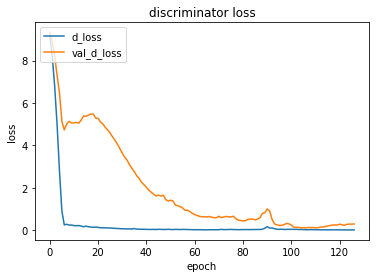

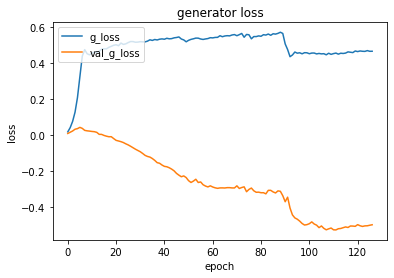

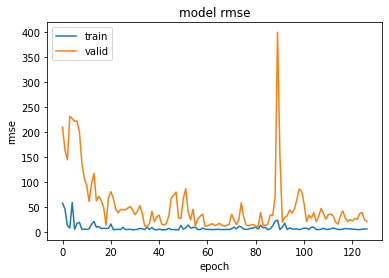

In [6]:
plot_d_loss(history)
plot_g_loss(history)
plot_rmse(history)

1 Day ahead
-- RMSE -- 1 Day ahead : 14.284085476390691
-- R2 -- 1 Day ahead : 0.9495647677975863
-- MAPE -- 1 Day ahead : 0.03720877763507405
-- POCID -- 1 Day ahead : 46.73157162726008
-- SLG -- 1 Day ahead : -0.03390820584144748 



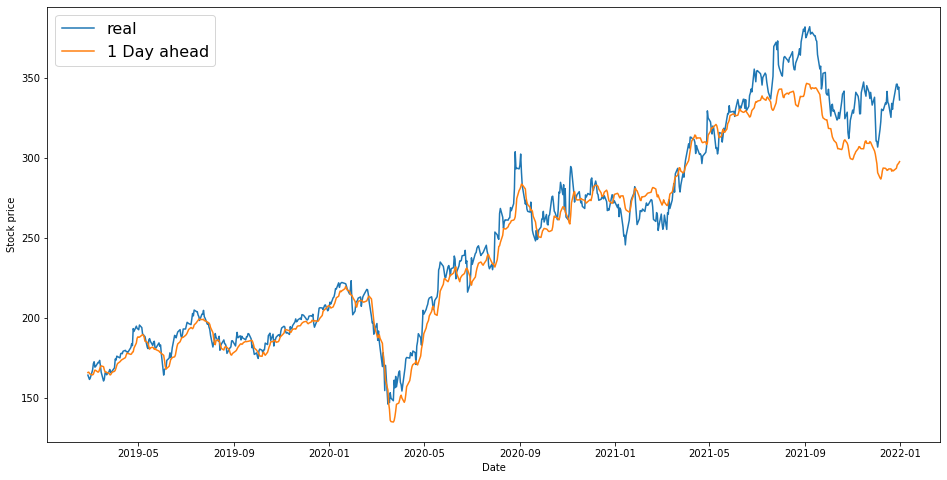

In [7]:
#----------------------    Test    -----------------------

# Load test data & model
path = r'Data\dataPreprocessed'
test_predict_index = np.load(os.path.join(path,"index_test.npy"), allow_pickle=True)
X_test = np.load(os.path.join(path,"X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path,"y_test.npy"), allow_pickle=True)
G_model = models.load_model(r'Models\trying\wgan_gp_best.h5')

if N_STEPS_OUT > 1:
    get_test_global_metrics(X_test, y_test, G_model, y_scaler_function)
plot_test_pred(X_test, y_test, G_model, y_scaler_function, test_predict_index)

# Arima

In [8]:
#----------------------    Load Data    -----------------------
data = pd.read_csv(r'Data\DataFacebook.csv', parse_dates=['date'])
close_price = data[['date', 'close']].copy()
y_scaler_function = all_preprocessing(close_price, N_STEPS_IN, N_STEPS_OUT, is_arima=True)

path = r'Data\dataPreprocessed'
# train == test for arima
X_test = np.load(os.path.join(path, "X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path, "y_test.npy"), allow_pickle=True)
test_predict_index = np.load(os.path.join(path,"index_test.npy"), allow_pickle=True)

X shape:  (2419, 3, 1)
y shape:  (2419, 1)
X_train shape:  (1693, 3, 1)
y_train shape:  (1693, 1)
y_c_train shape:  (1693, 3, 1)
X_test shape:  (726, 3, 1)
y_test shape:  (726, 1)
y_c_test shape:  (726, 3, 1)
index_train shape: (1693,)
index_test shape: (726,)
Everything saved in  Data\dataPreprocessed


In [9]:
#----------------------    Prediction    -----------------------
pred_arima = []
nb_pred = len(X_test)
for i, sample in enumerate(X_test):
    arima_model = auto_arima(sample)
    pred = arima_model.predict(n_periods=N_STEPS_OUT)
    pred_arima.append(pred)
    print(i + 1, '/', nb_pred)

1 / 726
2 / 726
3 / 726
4 / 726
5 / 726
6 / 726
7 / 726
8 / 726
9 / 726
10 / 726
11 / 726
12 / 726
13 / 726
14 / 726
15 / 726
16 / 726
17 / 726
18 / 726
19 / 726
20 / 726
21 / 726
22 / 726
23 / 726
24 / 726
25 / 726
26 / 726
27 / 726
28 / 726
29 / 726
30 / 726
31 / 726
32 / 726
33 / 726
34 / 726
35 / 726
36 / 726
37 / 726
38 / 726
39 / 726
40 / 726
41 / 726
42 / 726
43 / 726
44 / 726
45 / 726
46 / 726
47 / 726
48 / 726
49 / 726
50 / 726
51 / 726
52 / 726
53 / 726
54 / 726
55 / 726
56 / 726
57 / 726
58 / 726
59 / 726
60 / 726
61 / 726
62 / 726
63 / 726
64 / 726
65 / 726
66 / 726
67 / 726
68 / 726
69 / 726
70 / 726
71 / 726
72 / 726
73 / 726
74 / 726
75 / 726
76 / 726
77 / 726
78 / 726
79 / 726
80 / 726
81 / 726
82 / 726
83 / 726
84 / 726
85 / 726
86 / 726
87 / 726
88 / 726
89 / 726
90 / 726
91 / 726
92 / 726
93 / 726
94 / 726
95 / 726
96 / 726
97 / 726
98 / 726
99 / 726
100 / 726
101 / 726
102 / 726
103 / 726
104 / 726
105 / 726
106 / 726
107 / 726
108 / 726
109 / 726
110 / 726
111 / 72

1 Day ahead
-- RMSE -- 1 Day ahead : 6.636908311041104
-- R2 -- 1 Day ahead : 0.9891926243405518
-- MAPE -- 1 Day ahead : 0.019978529066302195
-- POCID -- 1 Day ahead : 45.93103448275862
-- SLG -- 1 Day ahead : 0.009006896551724023 



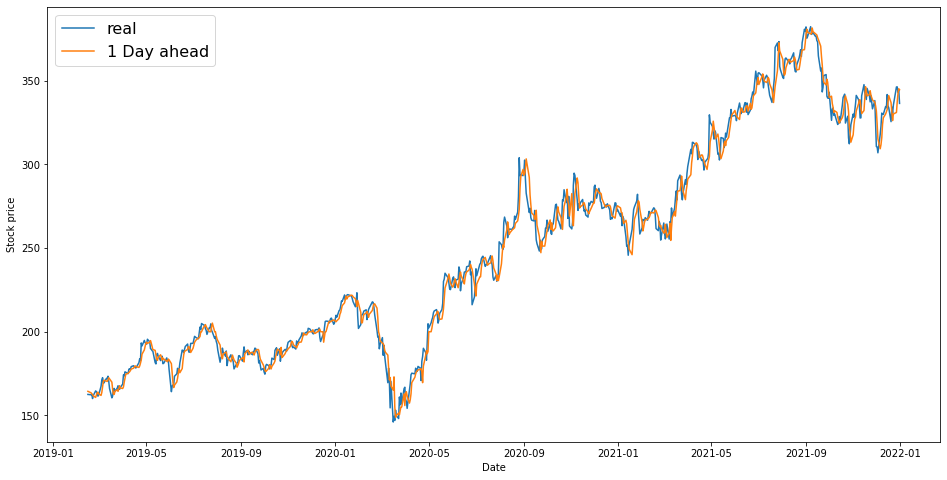

In [10]:
#----------------------    Test    -----------------------

if N_STEPS_OUT > 1:
        get_test_global_metrics(X_test, y_test, None, y_scaler_function, pred_arima=pred_arima)
plot_test_pred(X_test, y_test, None, y_scaler_function, test_predict_index, pred_arima=pred_arima)


# Simple GRU

In [11]:
EPOCHS = 200
BATCH_SIZE = 128
LEARNING_RATE = 0.0001

In [12]:
#----------------------    Load Data    -----------------------
data = pd.read_csv(r'Data\DataFacebook.csv', parse_dates=['date'])
y_scaler_function = all_preprocessing(data, N_STEPS_IN, N_STEPS_OUT)

path = r'Data\dataPreprocessed'
X_train = np.load(os.path.join(path, "X_train.npy"), allow_pickle=True)
y_train = np.load(os.path.join(path, "y_train.npy"), allow_pickle=True)
X_test = np.load(os.path.join(path, "X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path, "y_test.npy"), allow_pickle=True)
yc_train = np.load(os.path.join(path, "yc_train.npy"), allow_pickle=True)
yc_test = np.load(os.path.join(path, "yc_test.npy"), allow_pickle=True)

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

X shape:  (2399, 3, 36)
y shape:  (2399, 1)
X_train shape:  (1679, 3, 36)
y_train shape:  (1679, 1)
y_c_train shape:  (1679, 3, 1)
X_test shape:  (720, 3, 36)
y_test shape:  (720, 1)
y_c_test shape:  (720, 3, 1)
index_train shape: (1679,)
index_test shape: (720,)
Everything saved in  Data\dataPreprocessed


In [13]:
#----------------------    Training    -----------------------

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

es = callbacks.EarlyStopping(verbose=1, patience=10)
save_path = r'Models\trying\gru_best.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=save_path, save_best_only=True)

callback = [es, checkpoint]

model = simple_gru(input_dim, output_dim, feature_size)

model.compile(optimizer=optimizer, loss='mse')
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_data=(X_test, y_test), callbacks=callback,
                    verbose=2, shuffle=False)

Epoch 1/200
14/14 - 10s - loss: 0.6173 - val_loss: 0.2812
Epoch 2/200
14/14 - 0s - loss: 0.3134 - val_loss: 0.2448
Epoch 3/200
14/14 - 0s - loss: 0.1482 - val_loss: 0.2177
Epoch 4/200
14/14 - 0s - loss: 0.0773 - val_loss: 0.1934
Epoch 5/200
14/14 - 0s - loss: 0.0508 - val_loss: 0.1692
Epoch 6/200
14/14 - 0s - loss: 0.0383 - val_loss: 0.1456
Epoch 7/200
14/14 - 0s - loss: 0.0328 - val_loss: 0.1260
Epoch 8/200
14/14 - 0s - loss: 0.0299 - val_loss: 0.1092
Epoch 9/200
14/14 - 0s - loss: 0.0262 - val_loss: 0.0951
Epoch 10/200
14/14 - 0s - loss: 0.0229 - val_loss: 0.0843
Epoch 11/200
14/14 - 0s - loss: 0.0215 - val_loss: 0.0765
Epoch 12/200
14/14 - 0s - loss: 0.0178 - val_loss: 0.0701
Epoch 13/200
14/14 - 0s - loss: 0.0206 - val_loss: 0.0641
Epoch 14/200
14/14 - 0s - loss: 0.0174 - val_loss: 0.0601
Epoch 15/200
14/14 - 0s - loss: 0.0186 - val_loss: 0.0567
Epoch 16/200
14/14 - 0s - loss: 0.0171 - val_loss: 0.0543
Epoch 17/200
14/14 - 0s - loss: 0.0162 - val_loss: 0.0525
Epoch 18/200
14/14 - 0

Epoch 142/200
14/14 - 0s - loss: 0.0063 - val_loss: 0.0108
Epoch 143/200
14/14 - 0s - loss: 0.0063 - val_loss: 0.0114
Epoch 144/200
14/14 - 0s - loss: 0.0061 - val_loss: 0.0125
Epoch 145/200
14/14 - 0s - loss: 0.0057 - val_loss: 0.0128
Epoch 146/200
14/14 - 0s - loss: 0.0062 - val_loss: 0.0111
Epoch 147/200
14/14 - 0s - loss: 0.0065 - val_loss: 0.0119
Epoch 148/200
14/14 - 0s - loss: 0.0059 - val_loss: 0.0116
Epoch 149/200
14/14 - 0s - loss: 0.0060 - val_loss: 0.0110
Epoch 150/200
14/14 - 0s - loss: 0.0062 - val_loss: 0.0116
Epoch 151/200
14/14 - 0s - loss: 0.0064 - val_loss: 0.0110
Epoch 152/200
14/14 - 0s - loss: 0.0060 - val_loss: 0.0104
Epoch 153/200
14/14 - 0s - loss: 0.0054 - val_loss: 0.0106
Epoch 154/200
14/14 - 0s - loss: 0.0060 - val_loss: 0.0105
Epoch 155/200
14/14 - 0s - loss: 0.0059 - val_loss: 0.0099
Epoch 156/200
14/14 - 0s - loss: 0.0056 - val_loss: 0.0098
Epoch 157/200
14/14 - 0s - loss: 0.0055 - val_loss: 0.0103
Epoch 158/200
14/14 - 0s - loss: 0.0056 - val_loss: 0.01

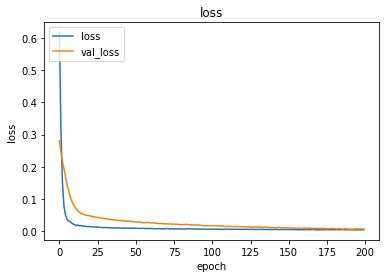

In [14]:
plot_loss(history)

1 Day ahead
-- RMSE -- 1 Day ahead : 15.202526437017807
-- R2 -- 1 Day ahead : 0.942870466396101
-- MAPE -- 1 Day ahead : 0.04028961524941324
-- POCID -- 1 Day ahead : 47.009735744089014
-- SLG -- 1 Day ahead : -0.0010013908205836293 



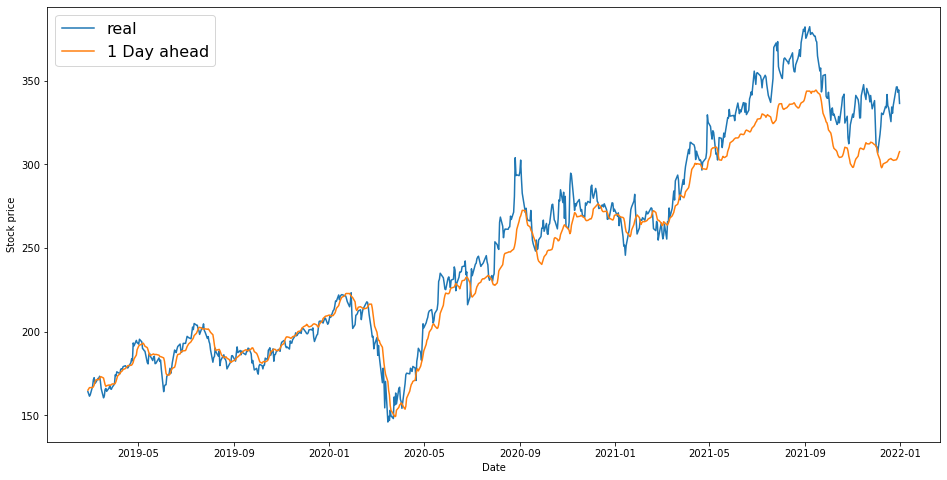

In [15]:
#----------------------    Test    -----------------------

# Load test data & model
path = r'Data\dataPreprocessed'
test_predict_index = np.load(os.path.join(path,"index_test.npy"), allow_pickle=True)
X_test = np.load(os.path.join(path,"X_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(path,"y_test.npy"), allow_pickle=True)
test_model = models.load_model(save_path )

if N_STEPS_OUT > 1:
    get_test_global_metrics(X_test, y_test, test_model, y_scaler_function)
plot_test_pred(X_test, y_test, test_model, y_scaler_function, test_predict_index)